<a href="https://colab.research.google.com/github/siteshh12/Shareyourstory/blob/main/Big_Mart_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

Data Collection and Processing

In [ ]:
# loading the data from csv file to Pandas DataFrame
big_mart_data = pd.read_csv('/content/Train.csv')

In [ ]:
# first 5 rows of the dataframe
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
# number of data points & number of features
big_mart_data.shape

(8523, 12)

In [ ]:
# getting some information about thye dataset
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Categorical Features:

Item_Identifier  
Item_Fat_Content  
Item_Type  
Outlet_Identifier  
Outlet_Size  
Outlet_Location_Type  
Outlet_Type  

In [ ]:
# checking for missing values
big_mart_data.isnull().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


Handling Missing Values  

Mean --> average  

Mode --> more repeated value  

In [ ]:
# mean value of "Item_Weight" column
big_mart_data['Item_Weight'].mean()

np.float64(12.857645184135976)

In [ ]:
# filling the missing values in "Item_weight column" with "Mean" value
big_mart_data.fillna({'Item_Weight': big_mart_data['Item_Weight'].mean()}, inplace=True)

In [ ]:
# mode of "Outlet_Size" column
big_mart_data['Outlet_Size'].mode()

,Outlet_Size
0,Medium


In [ ]:
# filling the missing values in "Outlet_Size" column with Mode
mode_of_Outlet_size = big_mart_data.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [ ]:
print(mode_of_Outlet_size)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  


In [ ]:
miss_values = big_mart_data['Outlet_Size'].isnull()

In [ ]:
print(miss_values)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [ ]:
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])

In [ ]:
# checking for missing values
big_mart_data.isnull().sum()

,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


Data Analysis

In [ ]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


Numerical Features

In [ ]:
sns.set()

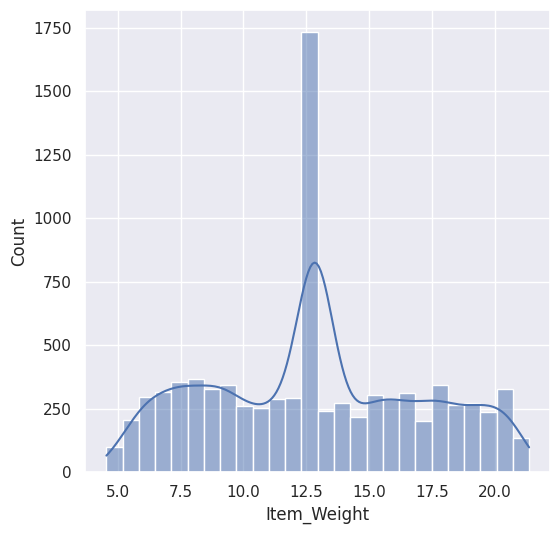

In [ ]:
# Item_Weight distribution
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_Weight'], kde=True)
plt.show()

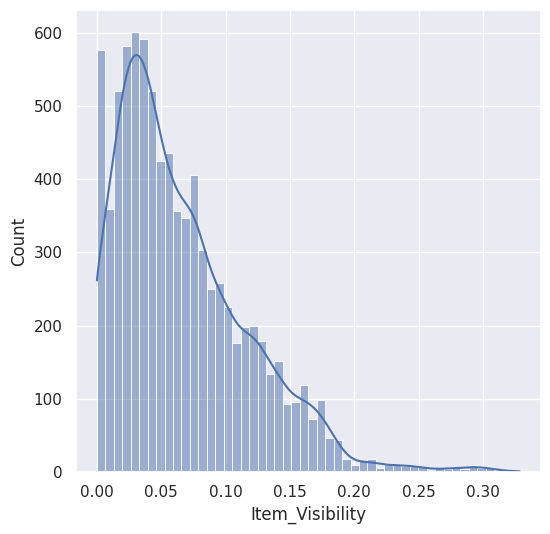

In [ ]:
# Item Visibility distribution
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_Visibility'], kde=True)
plt.show()

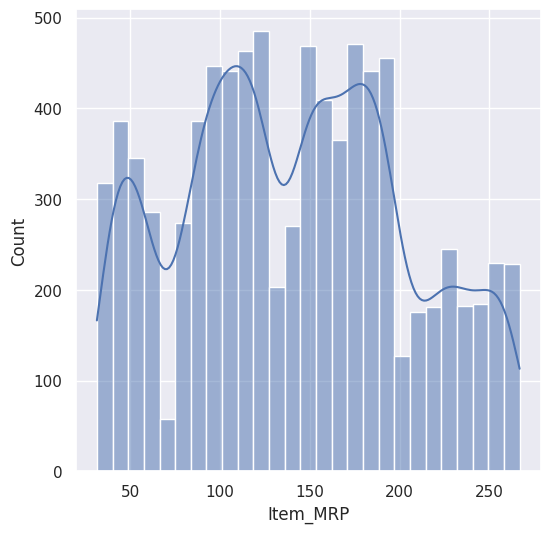

In [ ]:
# Item MRP distribution
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_MRP'], kde=True)
plt.show()

In [ ]:
print(big_mart_data.columns)

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')


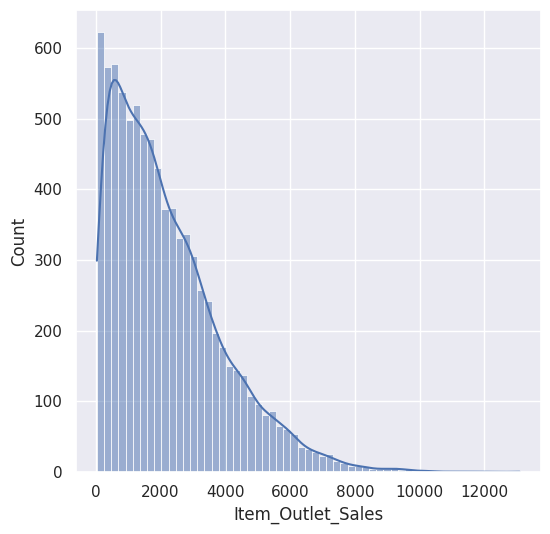

In [ ]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(6,6))
sns.histplot(big_mart_data['Item_Outlet_Sales'], kde=True)
plt.show()

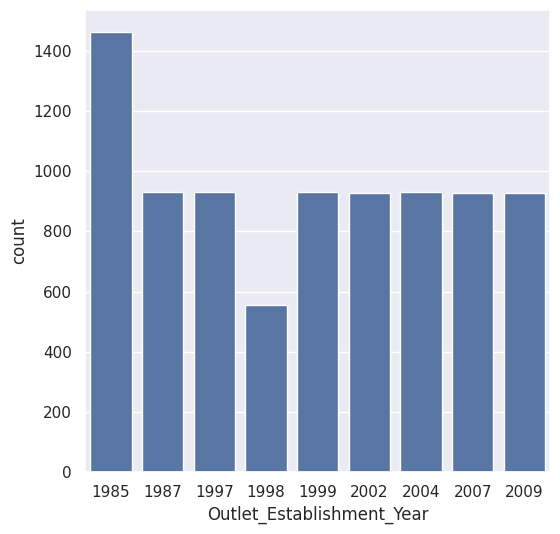

In [ ]:
# Outlet_Establishment_Year column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data)
plt.show()

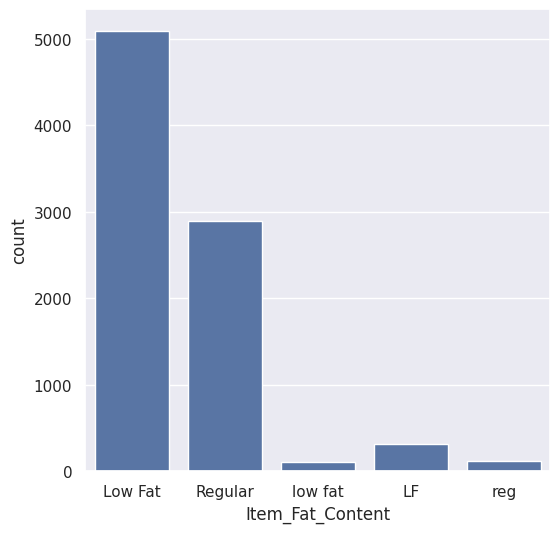

In [ ]:
# Item_Fat_Content column
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=big_mart_data)
plt.show()

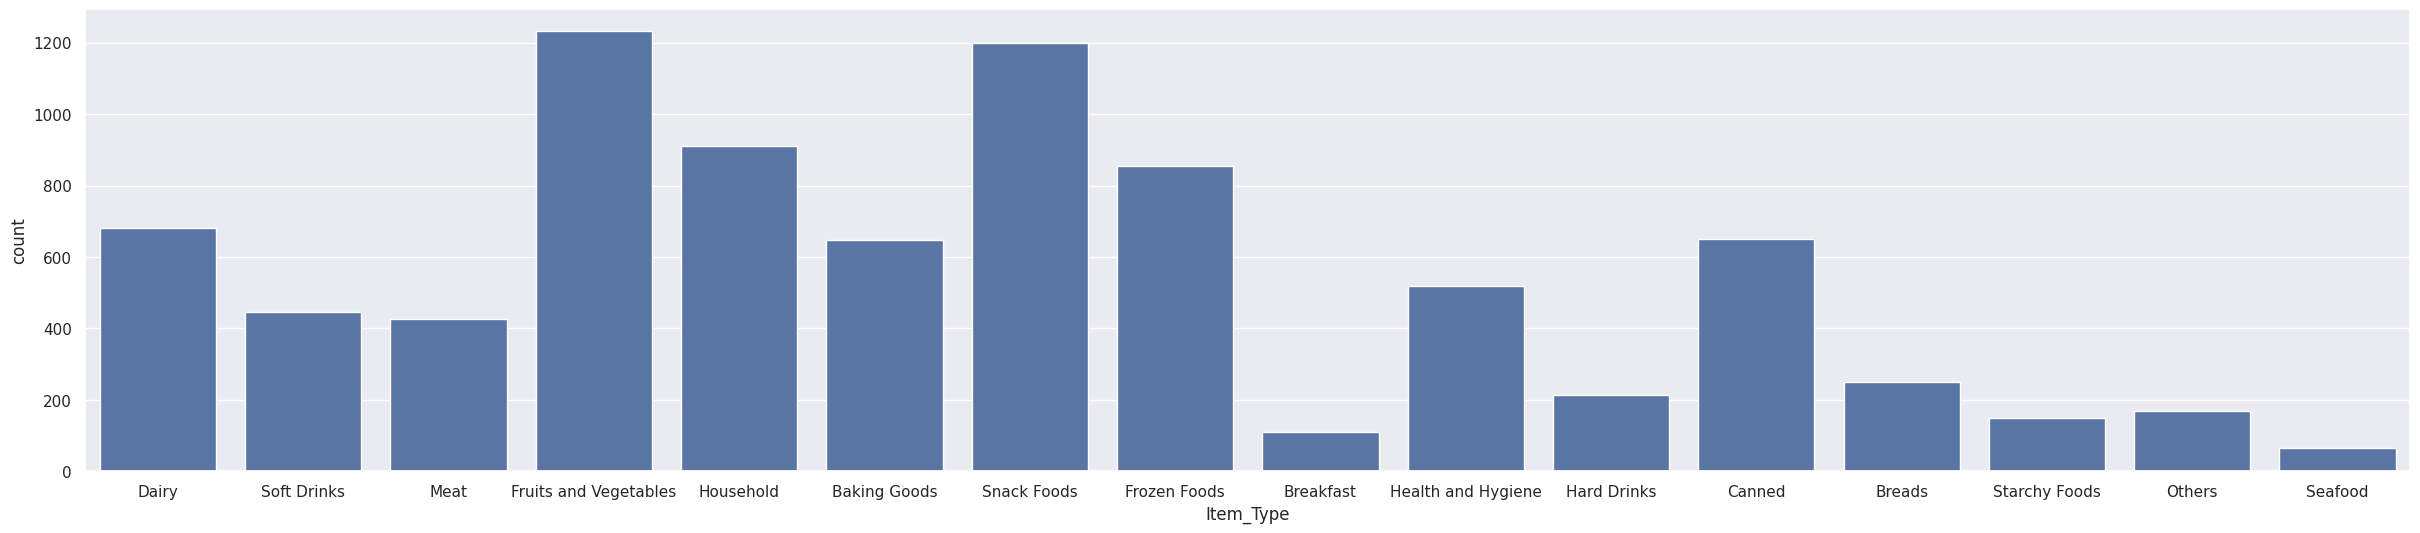

In [ ]:
# Item_Type column
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=big_mart_data)
plt.show()

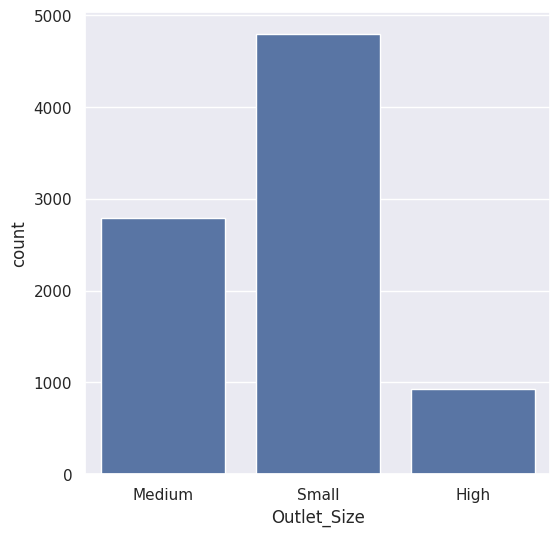

In [ ]:
# Outlet_Size column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Size', data=big_mart_data)
plt.show()

Data Pre-Processing

In [ ]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
big_mart_data['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5089
Regular,2889
LF,316
reg,117
low fat,112


In [ ]:
big_mart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [ ]:
big_mart_data['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


Label Encoding

In [ ]:
encoder = LabelEncoder()

In [ ]:
big_mart_data['Item_Identifier'] = encoder.fit_transform(big_mart_data['Item_Identifier'])

big_mart_data['Item_Fat_Content'] = encoder.fit_transform(big_mart_data['Item_Fat_Content'])

big_mart_data['Item_Type'] = encoder.fit_transform(big_mart_data['Item_Type'])

big_mart_data['Outlet_Identifier'] = encoder.fit_transform(big_mart_data['Outlet_Identifier'])

big_mart_data['Outlet_Size'] = encoder.fit_transform(big_mart_data['Outlet_Size'])

big_mart_data['Outlet_Location_Type'] = encoder.fit_transform(big_mart_data['Outlet_Location_Type'])

big_mart_data['Outlet_Type'] = encoder.fit_transform(big_mart_data['Outlet_Type'])

In [ ]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


Splitting features and Target

In [ ]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']

In [ ]:
print(X)

      Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      Item_Type  Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
0             4  249.8092                  9    

In [ ]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: Item_Outlet_Sales, Length: 8523, dtype: float64


Splitting the data into Training data & Testing Data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (6818, 11) (1705, 11)


Machine Learning Model Training

XGBoost Regressor

In [ ]:
regressor = XGBRegressor()

In [ ]:
regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Evaluation

In [ ]:
# prediction on training data
training_data_prediction = regressor.predict(X_train)

In [ ]:
# R squared Value
r2_train = metrics.r2_score(Y_train, training_data_prediction)

In [ ]:
print('R Squared value = ', r2_train)

R Squared value =  0.8762174618111388


In [ ]:
# prediction on test data
test_data_prediction = regressor.predict(X_test)

In [ ]:
# R squared Value
r2_test = metrics.r2_score(Y_test, test_data_prediction)

In [ ]:
print('R Squared value = ', r2_test)

R Squared value =  0.5017253991620692
